# PseudoBulk analysis to perform Differential Expression analysis

In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import pandas as pd
import os
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
adata= ad.read_h5ad("/home/jiguo/data/data/anndata/adata_all_pp_cc.h5")
adata

AnnData object with n_obs × n_vars = 12572 × 11428
    obs: 'condition', 'replicate', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes', 'S_score', 'G2M_score', 'phase'
    var: 'ensembl_gene_id', 'gene_name', 'in_jakobsen', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'log', 'normalised', 'regress_cc'

In [3]:
adata.obs['sample'] = (
		adata.obs['condition'].astype(str) + '_' +
		adata.obs['replicate'].astype(str)
)
adata.X = adata.layers['counts'].copy()

In [6]:
pseudobulk_counts = pd.DataFrame(
		columns = adata.var_names,
		index = adata.obs['sample'].unique()
)

for sample in pseudobulk_counts.index:
		# Get cell indices for this sample
		sample_mask = adata.obs['sample'] == sample
		
		# Sum raw counts (use counts layer if available)
		if 'counts' in adata.layers:
				sample_counts = adata.layers['counts'][sample_mask].sum(axis=0)
		else:
				sample_counts = adata[sample_mask].X.sum(axis=0)
		
		#Handle sparse matrices
		if hasattr(sample_counts, 'A1'):
				pseudobulk_counts.loc[sample] = sample_counts.A1
		else:
				pseudobulk_counts.loc[sample] = sample_counts

In [7]:
pseudobulk_meta = adata.obs[
		['condition', 'replicate', 'sample']
].drop_duplicates().set_index('sample')

In [8]:
pseudobulk_adata = sc.AnnData(
    X=sparse.csr_matrix(pseudobulk_counts.fillna(0)),
    obs=pseudobulk_meta,
    var=adata.var
)

In [9]:
sc.pp.normalize_total(pseudobulk_adata, target_sum=1e6)  # CPM normalization
sc.pp.log1p(pseudobulk_adata)  # Log transform

In [10]:
sc.tl.rank_genes_groups(
		pseudobulk_adata,
		groupby='condition',
		method='t-test_overestim_var',
		use_raw=False
)

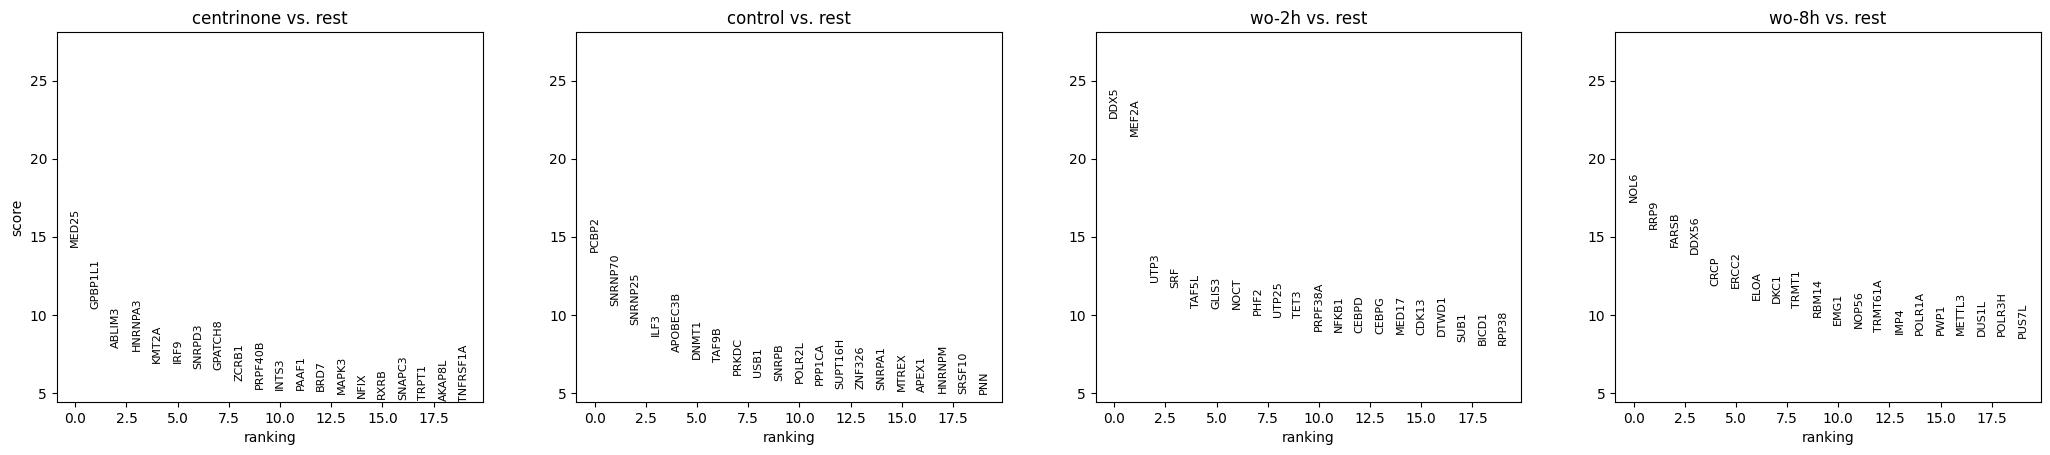

In [11]:
# 8. Visualization
sc.pl.rank_genes_groups(pseudobulk_adata, n_genes=20 )

In [12]:
# load 2 other list of genes related to mRNA processing and rRNA processing to label them in the volcano plot

def extract_de_results(adata, condition):
    # The input parameter 'condition' should be the CONTROL condition
    all_conditions = adata.obs['condition'].unique()
    control_condition = condition  # This is correct
    conditions = [c for c in all_conditions if c != control_condition]
    
    de_results = {}
    all_results_list = []  # To store all results for saving later
    for cond in conditions:
        # Should use the current adata parameter, not pseudobulk_adata
        de_df = sc.get.rank_genes_groups_df(
            adata,  # Fixed: use input adata
            group=cond,
            key='rank_genes_groups' 
        )
        de_df['-log10_pvals_adj'] = -np.log10(de_df['pvals_adj'])  # Use adjusted p-values
        de_df = de_df.merge(
            adata.var[['gene_name']],  # Fixed: use input adata
            left_on='names',
            right_index=True
        )
        # Add condition information
        de_df['comparison'] = f"{control_condition}_vs_{cond}"
        de_df['control'] = control_condition
        de_df['treatment'] = cond
        de_results[cond] = de_df
        all_results_list.append(de_df)
    # save the results to a file under the /home/jiguo/output/
    all_results_df = pd.concat(all_results_list)
    # Save to file
    output_file = f"/home/jiguo/output/pseudobulk_analysis/de_results_{control_condition}.csv"
    all_results_df.to_csv(output_file, index=False)
    print(f"DE results saved to {output_file} with condition information")
    return de_results, control_condition

def plot_volcano(de_results, control_condition):
    # Get conditions from de_results keys, not adata.obs
    conditions = list(de_results.keys())
    n_conditions = len(conditions)
    mRNA_genes = pd.read_csv("/home/jiguo/denovo_rpe1_scrnaseq/mRNA_processing.txt",delimiter='\t')['Gene_name'].tolist()
    # Calculate grid dimensions
    n_cols = min(2, n_conditions)
    n_rows = (n_conditions + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, 6*n_rows))
    sns.set(style='whitegrid', font_scale=1.2)
    
    for i, cond in enumerate(conditions, 1):
        df = de_results[cond]
        ax = plt.subplot(n_rows, n_cols, i)  # Fixed index: use i not i+1
        
        # Significance thresholds (use pvals_adj for FDR)
        sig_threshold = 0.05
        logfc_threshold = 1
        
        df['significance'] = 'Not significant'
        df.loc[(df['pvals_adj'] < sig_threshold) &  # Use ADJUSTED p-values
               (df['logfoldchanges'] > logfc_threshold), 'significance'] = 'Up-regulated'
        df.loc[(df['pvals_adj'] < sig_threshold) &  # Use ADJUSTED p-values
               (df['logfoldchanges'] < -logfc_threshold), 'significance'] = 'Down-regulated'
        

        sns.scatterplot(
            data=df,
            x='logfoldchanges',
            y='-log10_pvals_adj',  # Match the column name
            hue='significance',
            palette={'Up-regulated': '#e41a1c', 
                    'Down-regulated': '#377eb8',
                    'Not significant': '#bdbdbd'},
            alpha=0.7,
            s=40,
            ax=ax
                )
        # Gene labeling - better approach
        df['combined_score'] = np.abs(df['logfoldchanges']) * df['-log10_pvals_adj']
        top_genes = df.nlargest(10, 'combined_score')

        for _, row in top_genes.iterrows():
            ax.text(
                row['logfoldchanges'],
                row['-log10_pvals_adj'] + 0.1,  # Offset to avoid overlap
                row['gene_name'],
                fontsize=9,
                alpha=0.8,
                fontweight='bold'
            )
        
        # Add thresholds
        ax.axhline(-np.log10(sig_threshold), color='gray', linestyle='--', alpha=0.7)
        ax.axvline(logfc_threshold, color='gray', linestyle='--', alpha=0.7)
        ax.axvline(-logfc_threshold, color='gray', linestyle='--', alpha=0.7)
        
        # Correct title
        ax.set_title(f'{control_condition} vs {cond}', fontsize=16)  # Fixed title
        ax.set_xlabel('Log2 Fold Change', fontsize=14)
        ax.set_ylabel('-Log10(Adjusted p-value)', fontsize=14)
        ax.set_xlim(df['logfoldchanges'].min()-0.5, df['logfoldchanges'].max()+0.5)
        ax.legend().remove()  # Remove individual legends
    
    # Add common legend
    plt.tight_layout()
    handles, labels = ax.get_legend_handles_labels()
    plt.figlegend(handles, labels, loc='lower center', ncol=3, 
                  bbox_to_anchor=(0.5, -0.05 if n_rows > 1 else -0.1))
    
    return plt

DE results saved to /home/jiguo/output/pseudobulk_analysis/de_results_control.csv with condition information


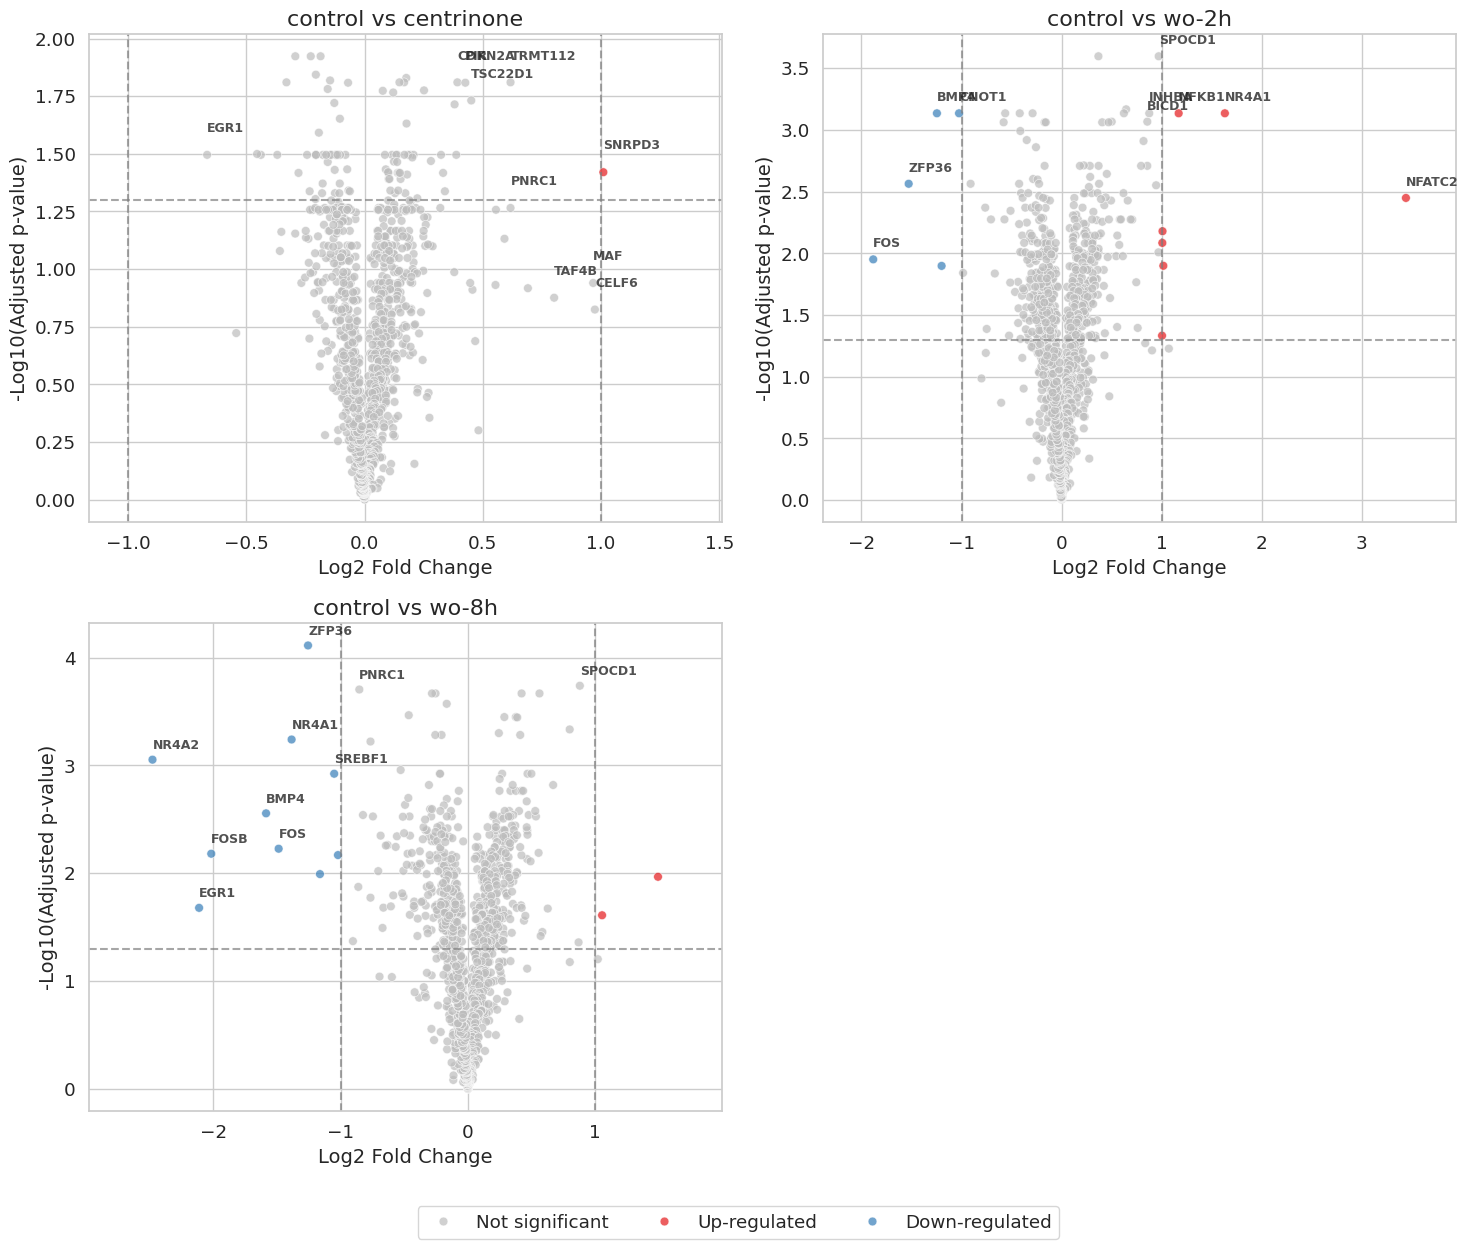

In [13]:
# First run DE analysis
sc.tl.rank_genes_groups(
    pseudobulk_adata,
    groupby='condition',
    reference='control',  # Set control as reference
    method='t-test_overestim_var'
)
# Extract results
de_results, control_condition = extract_de_results(
    pseudobulk_adata, 
    condition='control'  # Specify control condition
)

# Plot
fig = plot_volcano(de_results, control_condition)
# fig.savefig("/home/jiguo/output/pseudobulk_volcano_plots.png", 
            # dpi=300, bbox_inches='tight')
plt.show()

DE results saved to /home/jiguo/output/pseudobulk_analysis/de_results_centrinone.csv with condition information


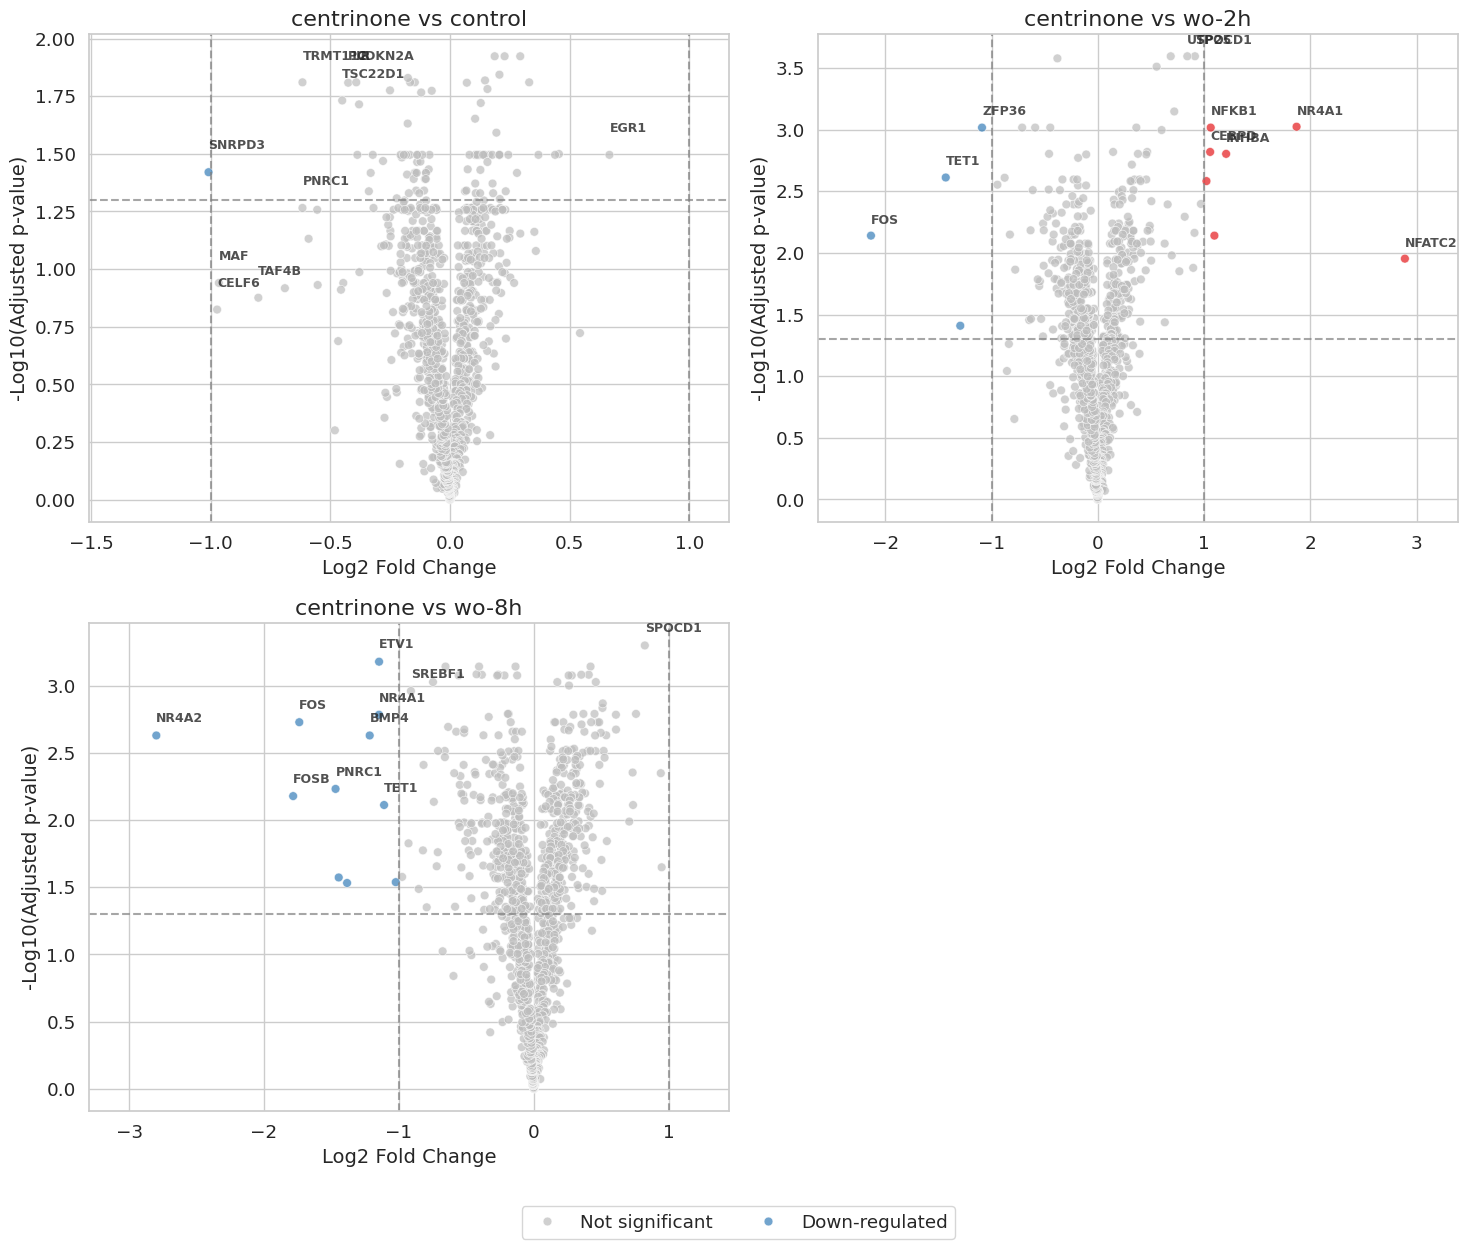

In [14]:
# First run DE analysis
sc.tl.rank_genes_groups(
    pseudobulk_adata,
    groupby='condition',
    reference='centrinone',  # Set control as reference
    method='t-test_overestim_var'
)
# Extract results
de_results, control_condition = extract_de_results(
    pseudobulk_adata, 
    condition='centrinone'  # Specify control condition
)

# Plot
fig = plot_volcano(de_results, control_condition)
# fig.savefig("/home/jiguo/output/pseudobulk_volcano_plots.png", 
            # dpi=300, bbox_inches='tight')
plt.show()

DE results saved to /home/jiguo/output/pseudobulk_analysis/de_results_wo-2h.csv with condition information


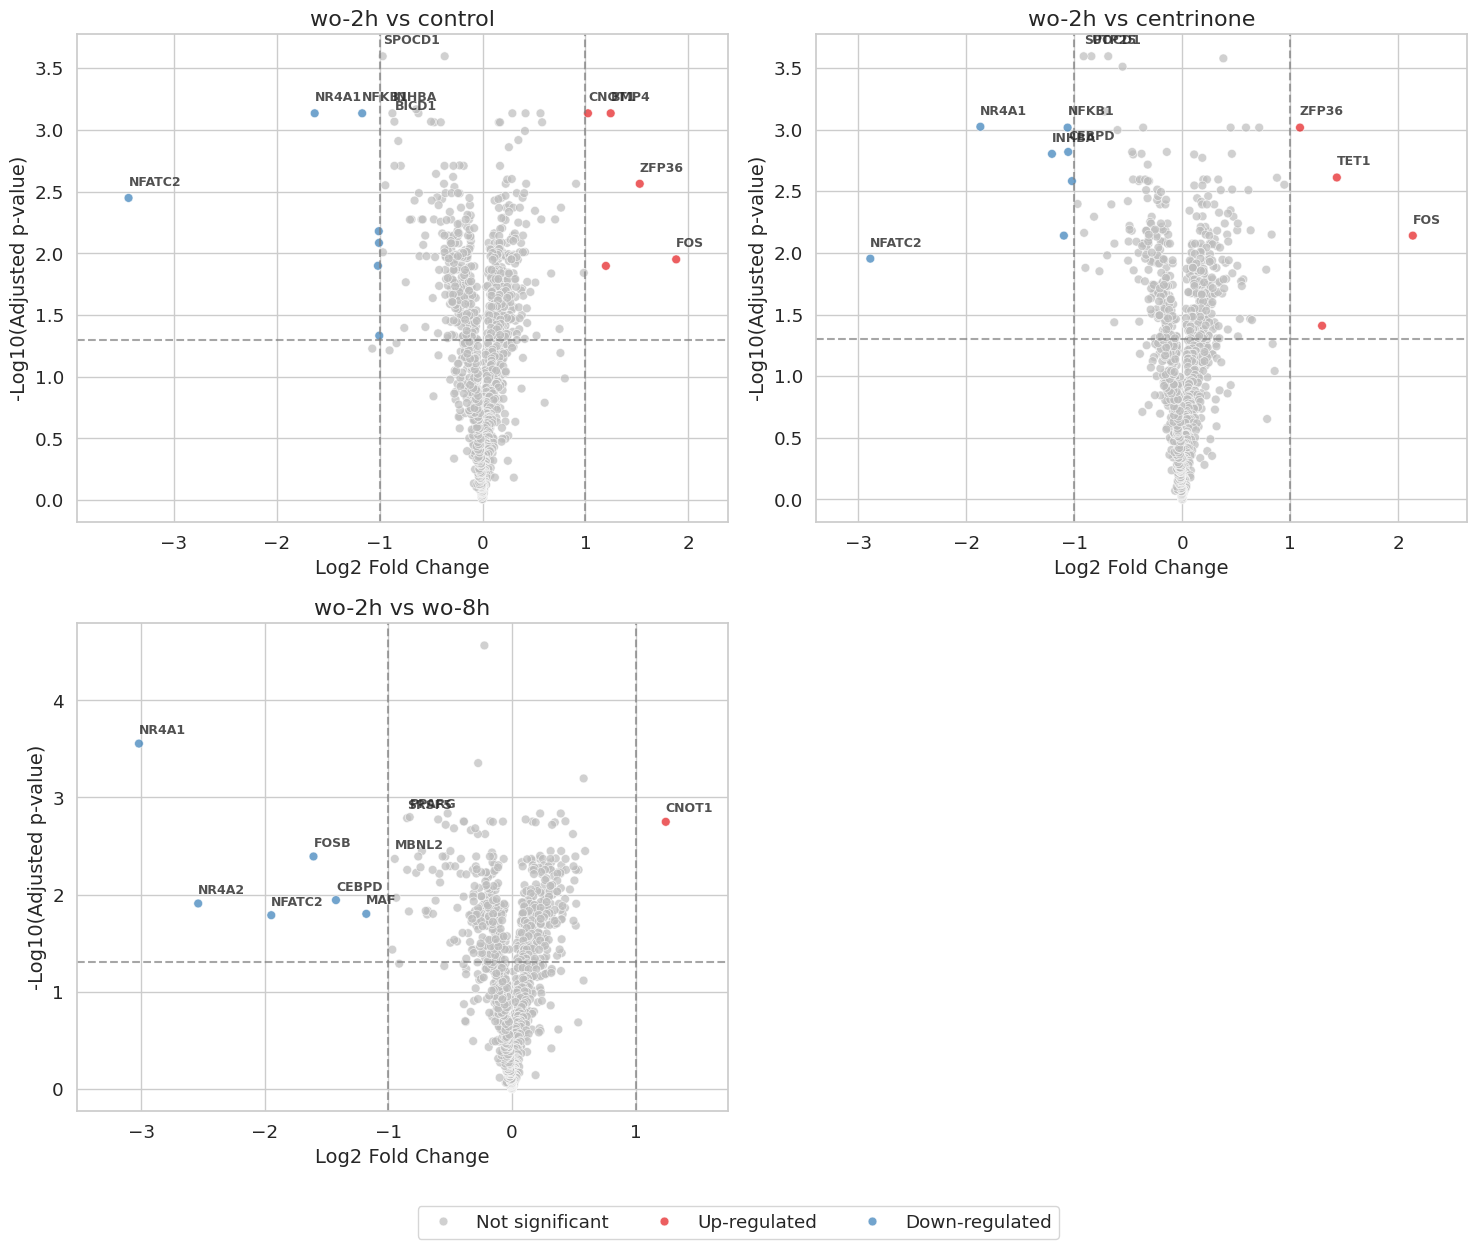

In [15]:
# First run DE analysis
sc.tl.rank_genes_groups(
    pseudobulk_adata,
    groupby='condition',
    reference='wo-2h',  
    method='t-test_overestim_var'
)
# Extract results
de_results, control_condition = extract_de_results(
    pseudobulk_adata, 
    condition='wo-2h'  
)

# Plot
fig = plot_volcano(de_results, control_condition)
# fig.savefig("/home/jiguo/output/pseudobulk_volcano_plots.png", 
            # dpi=300, bbox_inches='tight')
plt.show()

DE results saved to /home/jiguo/output/pseudobulk_analysis/de_results_wo-8h.csv with condition information


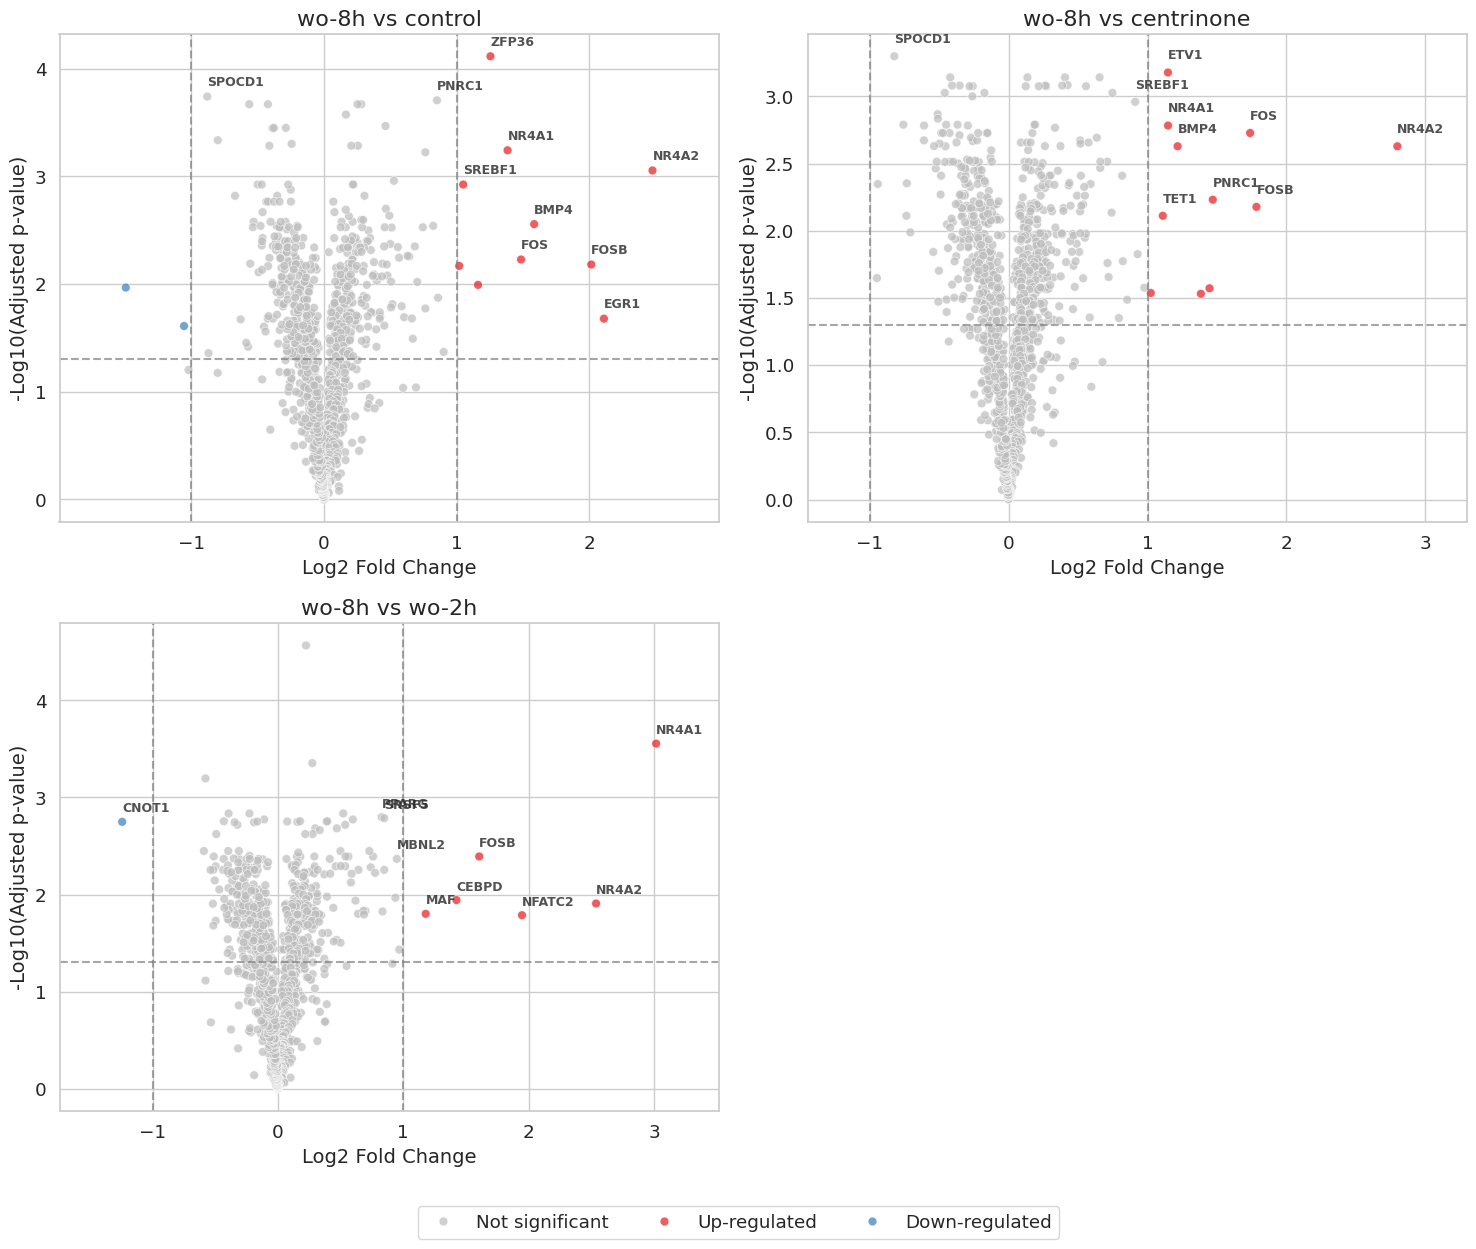

In [16]:
# First run DE analysis
sc.tl.rank_genes_groups(
    pseudobulk_adata,
    groupby='condition',
    reference='wo-8h',  # Set control as reference
    method='t-test_overestim_var'
)
# Extract results
de_results, control_condition = extract_de_results(
    pseudobulk_adata, 
    condition='wo-8h'  # Specify control condition
)

# Plot
fig = plot_volcano(de_results, control_condition)
# fig.savefig("/home/jiguo/output/pseudobulk_volcano_plots.png", 
            # dpi=300, bbox_inches='tight')
plt.show()

several genes in list A are up-regulated during the recovery of the centrioles, (wash out 2 hours vs wash out 8 hours)
comparing with control and centrinone treatments, some genes in list A are up regulated after centrosome recovery,(wo-8h vs control)
centrosome perturbation with centrinone does not significantly affect the expression of genes in list A(Control vs centrinone)
several genes in list A are also differentialy expressed at the start of the centrosome recovery (wo-2h vs control, wo-2h vs centrinone)

In [27]:
def extract_and_save_regulated_genes(file_path, control_condition, condition, output_dir="/home/jiguo/output/pseudobulk_analysis/genes_list"):
    """
    Extract both up-regulated and down-regulated genes and save as a comprehensive table
    """
    df = pd.read_csv(file_path)
    
    # Filter for the specific comparison
    comparison_data = df[df['comparison'] == f"{control_condition}_vs_{condition}"]
    
    # Up-regulated genes (using pvals_adj for consistency)
    upregulated = comparison_data[
        (comparison_data['pvals_adj'] < 0.05) & 
        (comparison_data['logfoldchanges'] > 1)
    ].copy()
    upregulated['regulation'] = 'Up-regulated'
    
    # Down-regulated genes (using pvals_adj for consistency)
    downregulated = comparison_data[
        (comparison_data['pvals_adj'] < 0.05) & 
        (comparison_data['logfoldchanges'] < -1)
    ].copy()
    downregulated['regulation'] = 'Down-regulated'
    
    # Combine both datasets
    regulated_genes = pd.concat([upregulated, downregulated], ignore_index=True)
    
    if not regulated_genes.empty:
        # Add metadata columns
        regulated_genes['control_condition'] = control_condition
        regulated_genes['comparison_condition'] = condition
        
        # Reorder columns for better readability
        columns_order = [
            'gene_name', 'regulation', 'control_condition', 'comparison_condition',
            'logfoldchanges', 'pvals', 'pvals_adj', 'comparison'
        ]
        # Add any additional columns that might exist
        remaining_cols = [col for col in regulated_genes.columns if col not in columns_order]
        final_columns = columns_order + remaining_cols
        
        regulated_genes = regulated_genes[final_columns]
        
        # Sort by absolute log fold change (descending)
        regulated_genes = regulated_genes.reindex(
            regulated_genes['logfoldchanges'].abs().sort_values(ascending=False).index
        )
        
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        
        # Save comprehensive table
        output_file = f"{output_dir}/regulated_genes_{control_condition}_vs_{condition}.csv"
        regulated_genes.to_csv(output_file, index=False)
        
        # Print summary
        print(f"Regulated genes in {condition} compared to {control_condition}:")
        print(f"Up-regulated: {len(upregulated)} genes")
        print(f"Down-regulated: {len(downregulated)} genes")
        print(f"Total regulated genes: {len(regulated_genes)}")
        print(f"\nResults saved to: {output_file}")
        
        # Print preview of the table
        print(f"\nPreview of regulated genes:")
        print(regulated_genes[['gene_name', 'regulation', 'logfoldchanges', 'pvals_adj']].head(10))
        
        # Also save individual gene lists for compatibility
        upregulated_genes = upregulated['gene_name'].tolist()
        downregulated_genes = downregulated['gene_name'].tolist()
        
        # Save upregulated genes list
        with open(f"{output_dir}/upregulated_genes_{control_condition}_vs_{condition}.txt", 'w') as f:
            for gene in upregulated_genes:
                f.write(f"{gene}\n")
        
        # Save downregulated genes list
        with open(f"{output_dir}/downregulated_genes_{control_condition}_vs_{condition}.txt", 'w') as f:
            for gene in downregulated_genes:
                f.write(f"{gene}\n")
                
        return regulated_genes
        
    else:
        print(f"No significantly regulated genes found for {condition} compared to {control_condition}.")
        return pd.DataFrame()

In [28]:
extract_and_save_regulated_genes(
    "/home/jiguo/output/pseudobulk_analysis/de_results_control.csv",
    control_condition='control', condition='centrinone')

Regulated genes in centrinone compared to control:
Up-regulated: 1 genes
Down-regulated: 0 genes
Total regulated genes: 1

Results saved to: /home/jiguo/output/pseudobulk_analysis/genes_list/regulated_genes_control_vs_centrinone.csv

Preview of regulated genes:
  gene_name    regulation  logfoldchanges  pvals_adj
0    SNRPD3  Up-regulated         1.00928   0.037985


,gene_name,regulation,control_condition,comparison_condition,logfoldchanges,pvals,pvals_adj,comparison,names,scores,-log10_pvals_adj,control,treatment
0,SNRPD3,Up-regulated,control,centrinone,1.00928,0.001902,0.037985,control_vs_centrinone,SNRPD3,7.65766,1.420384,control,centrinone


In [29]:
extract_and_save_regulated_genes(
    "/home/jiguo/output/pseudobulk_analysis/de_results_control.csv",
    control_condition='control', condition='wo-2h')

Regulated genes in wo-2h compared to control:
Up-regulated: 7 genes
Down-regulated: 5 genes
Total regulated genes: 12

Results saved to: /home/jiguo/output/pseudobulk_analysis/genes_list/regulated_genes_control_vs_wo-2h.csv

Preview of regulated genes:
   gene_name      regulation  logfoldchanges  pvals_adj
5     NFATC2    Up-regulated        3.441979   0.003560
8        FOS  Down-regulated       -1.882768   0.011197
0      NR4A1    Up-regulated        1.632172   0.000734
11     ZFP36  Down-regulated       -1.528455   0.002733
9       BMP4  Down-regulated       -1.246003   0.000734
7       EGR1  Down-regulated       -1.199270   0.012649
1      NFKB1    Up-regulated        1.170240   0.000734
10     CNOT1  Down-regulated       -1.024991   0.000734
4     SAMD4A    Up-regulated        1.017146   0.012623
3      KLF13    Up-regulated        1.008879   0.006623


,gene_name,regulation,control_condition,comparison_condition,logfoldchanges,pvals,pvals_adj,comparison,names,scores,-log10_pvals_adj,control,treatment
5,NFATC2,Up-regulated,control,wo-2h,3.441979,0.000155,0.003560,control_vs_wo-2h,NFATC2,16.190828,2.448588,control,wo-2h
8,FOS,Down-regulated,control,wo-2h,-1.882768,0.001854,0.011197,control_vs_wo-2h,FOS,-20.210451,1.950894,control,wo-2h
0,NR4A1,Up-regulated,control,wo-2h,1.632172,0.000005,0.000734,control_vs_wo-2h,NR4A1,32.954212,3.134513,control,wo-2h
11,ZFP36,Down-regulated,control,wo-2h,-1.528455,0.000079,0.002733,control_vs_wo-2h,ZFP36,-53.813170,2.563362,control,wo-2h
9,BMP4,Down-regulated,control,wo-2h,-1.246003,0.000004,0.000734,control_vs_wo-2h,BMP4,-35.963570,3.134513,control,wo-2h
7,EGR1,Down-regulated,control,wo-2h,-1.199270,0.002217,0.012649,control_vs_wo-2h,EGR1,-13.168798,1.897953,control,wo-2h
1,NFKB1,Up-regulated,control,wo-2h,1.170240,0.000006,0.000734,control_vs_wo-2h,NFKB1,31.347553,3.134513,control,wo-2h
10,CNOT1,Down-regulated,control,wo-2h,-1.024991,0.000006,0.000734,control_vs_wo-2h,CNOT1,-46.144688,3.134513,control,wo-2h
4,SAMD4A,Up-regulated,control,wo-2h,1.017146,0.002202,0.012623,control_vs_wo-2h,SAMD4A,19.708270,1.898854,control,wo-2h
3,KLF13,Up-regulated,control,wo-2h,1.008879,0.000530,0.006623,control_vs_wo-2h,KLF13,22.655443,2.178958,control,wo-2h


In [30]:
extract_and_save_regulated_genes(
    "/home/jiguo/output/pseudobulk_analysis/de_results_control.csv",
    control_condition='control', condition='wo-8h')

Regulated genes in wo-8h compared to control:
Up-regulated: 2 genes
Down-regulated: 10 genes
Total regulated genes: 12

Results saved to: /home/jiguo/output/pseudobulk_analysis/genes_list/regulated_genes_control_vs_wo-8h.csv

Preview of regulated genes:
   gene_name      regulation  logfoldchanges  pvals_adj
9      NR4A2  Down-regulated       -2.478451   0.000883
3       EGR1  Down-regulated       -2.112119   0.020963
5       FOSB  Down-regulated       -2.016569   0.006592
7       BMP4  Down-regulated       -1.585744   0.002780
0     NFATC2    Up-regulated        1.494768   0.010790
6        FOS  Down-regulated       -1.486940   0.005923
8      NR4A1  Down-regulated       -1.385051   0.000574
11     ZFP36  Down-regulated       -1.255993   0.000077
4      RBM47  Down-regulated       -1.162281   0.010188
1      TAF7L    Up-regulated        1.055131   0.024558


,gene_name,regulation,control_condition,comparison_condition,logfoldchanges,pvals,pvals_adj,comparison,names,scores,-log10_pvals_adj,control,treatment
9,NR4A2,Down-regulated,control,wo-8h,-2.478451,1.426092e-05,0.000883,control_vs_wo-8h,NR4A2,-35.898220,3.054162,control,wo-8h
3,EGR1,Down-regulated,control,wo-8h,-2.112119,6.282166e-03,0.020963,control_vs_wo-8h,EGR1,-11.350888,1.678544,control,wo-8h
5,FOSB,Down-regulated,control,wo-8h,-2.016569,8.365766e-04,0.006592,control_vs_wo-8h,FOSB,-23.490065,2.180989,control,wo-8h
7,BMP4,Down-regulated,control,wo-8h,-1.585744,1.167558e-04,0.002780,control_vs_wo-8h,BMP4,-27.983843,2.556004,control,wo-8h
0,NFATC2,Up-regulated,control,wo-8h,1.494768,2.109253e-03,0.010790,control_vs_wo-8h,NFATC2,10.542944,1.966966,control,wo-8h
6,FOS,Down-regulated,control,wo-8h,-1.486940,6.841970e-04,0.005923,control_vs_wo-8h,FOS,-25.597824,2.227434,control,wo-8h
8,NR4A1,Down-regulated,control,wo-8h,-1.385051,8.341011e-06,0.000574,control_vs_wo-8h,NR4A1,-29.168730,3.241333,control,wo-8h
11,ZFP36,Down-regulated,control,wo-8h,-1.255993,6.207960e-08,0.000077,control_vs_wo-8h,ZFP36,-100.778710,4.114330,control,wo-8h
4,RBM47,Down-regulated,control,wo-8h,-1.162281,1.902039e-03,0.010188,control_vs_wo-8h,RBM47,-15.658844,1.991900,control,wo-8h
1,TAF7L,Up-regulated,control,wo-8h,1.055131,8.212545e-03,0.024558,control_vs_wo-8h,TAF7L,4.944563,1.609802,control,wo-8h


In [31]:
extract_and_save_regulated_genes(
    "/home/jiguo/output/pseudobulk_analysis/de_results_centrinone.csv",
    control_condition='centrinone', condition='wo-2h')

Regulated genes in wo-2h compared to centrinone:
Up-regulated: 7 genes
Down-regulated: 4 genes
Total regulated genes: 11

Results saved to: /home/jiguo/output/pseudobulk_analysis/genes_list/regulated_genes_centrinone_vs_wo-2h.csv

Preview of regulated genes:
   gene_name      regulation  logfoldchanges  pvals_adj
6     NFATC2    Up-regulated        2.888753   0.011139
8        FOS  Down-regulated       -2.134285   0.007246
3      NR4A1    Up-regulated        1.869776   0.000948
9       TET1  Down-regulated       -1.430827   0.002448
7       LHX1  Down-regulated       -1.294085   0.038989
0      INHBA    Up-regulated        1.206996   0.001574
4     SAMD4A    Up-regulated        1.096613   0.007246
10     ZFP36  Down-regulated       -1.089710   0.000963
5      NFKB1    Up-regulated        1.062039   0.000963
2      CEBPD    Up-regulated        1.056621   0.001518


,gene_name,regulation,control_condition,comparison_condition,logfoldchanges,pvals,pvals_adj,comparison,names,scores,-log10_pvals_adj,control,treatment
6,NFATC2,Up-regulated,centrinone,wo-2h,2.888753,0.001365,0.011139,centrinone_vs_wo-2h,NFATC2,15.899240,1.953165,centrinone,wo-2h
8,FOS,Down-regulated,centrinone,wo-2h,-2.134285,0.000615,0.007246,centrinone_vs_wo-2h,FOS,-21.848745,2.139920,centrinone,wo-2h
3,NR4A1,Up-regulated,centrinone,wo-2h,1.869776,0.000005,0.000948,centrinone_vs_wo-2h,NR4A1,34.085785,3.023174,centrinone,wo-2h
9,TET1,Down-regulated,centrinone,wo-2h,-1.430827,0.000049,0.002448,centrinone_vs_wo-2h,TET1,-25.156782,2.611276,centrinone,wo-2h
7,LHX1,Down-regulated,centrinone,wo-2h,-1.294085,0.012157,0.038989,centrinone_vs_wo-2h,LHX1,-4.694323,1.409053,centrinone,wo-2h
0,INHBA,Up-regulated,centrinone,wo-2h,1.206996,0.000025,0.001574,centrinone_vs_wo-2h,INHBA,66.160780,2.803037,centrinone,wo-2h
4,SAMD4A,Up-regulated,centrinone,wo-2h,1.096613,0.000612,0.007246,centrinone_vs_wo-2h,SAMD4A,32.456250,2.139920,centrinone,wo-2h
10,ZFP36,Down-regulated,centrinone,wo-2h,-1.089710,0.000008,0.000963,centrinone_vs_wo-2h,ZFP36,-29.479378,3.016188,centrinone,wo-2h
5,NFKB1,Up-regulated,centrinone,wo-2h,1.062039,0.000010,0.000963,centrinone_vs_wo-2h,NFKB1,30.053650,3.016188,centrinone,wo-2h
2,CEBPD,Up-regulated,centrinone,wo-2h,1.056621,0.000020,0.001518,centrinone_vs_wo-2h,CEBPD,35.172370,2.818684,centrinone,wo-2h


In [32]:
extract_and_save_regulated_genes(
    "/home/jiguo/output/pseudobulk_analysis/de_results_centrinone.csv",
    control_condition='centrinone', condition='wo-8h')

Regulated genes in wo-8h compared to centrinone:
Up-regulated: 0 genes
Down-regulated: 11 genes
Total regulated genes: 11

Results saved to: /home/jiguo/output/pseudobulk_analysis/genes_list/regulated_genes_centrinone_vs_wo-8h.csv

Preview of regulated genes:
   gene_name      regulation  logfoldchanges  pvals_adj
9      NR4A2  Down-regulated       -2.798356   0.002353
5       FOSB  Down-regulated       -1.784018   0.006646
7        FOS  Down-regulated       -1.738457   0.001874
8      PNRC1  Down-regulated       -1.469583   0.005877
2       EGR1  Down-regulated       -1.446165   0.026786
0        MAF  Down-regulated       -1.384091   0.029439
4       BMP4  Down-regulated       -1.216456   0.002353
6      NR4A1  Down-regulated       -1.147448   0.001649
10      ETV1  Down-regulated       -1.147018   0.000665
3       TET1  Down-regulated       -1.109935   0.007742


,gene_name,regulation,control_condition,comparison_condition,logfoldchanges,pvals,pvals_adj,comparison,names,scores,-log10_pvals_adj,control,treatment
9,NR4A2,Down-regulated,centrinone,wo-8h,-2.798356,0.000114,0.002353,centrinone_vs_wo-8h,NR4A2,-45.973620,2.628392,centrinone,wo-8h
5,FOSB,Down-regulated,centrinone,wo-8h,-1.784018,0.000907,0.006646,centrinone_vs_wo-8h,FOSB,-20.533806,2.177431,centrinone,wo-8h
7,FOS,Down-regulated,centrinone,wo-8h,-1.738457,0.000062,0.001874,centrinone_vs_wo-8h,FOS,-26.702680,2.727117,centrinone,wo-8h
8,PNRC1,Down-regulated,centrinone,wo-8h,-1.469583,0.000688,0.005877,centrinone_vs_wo-8h,PNRC1,-30.125809,2.230847,centrinone,wo-8h
2,EGR1,Down-regulated,centrinone,wo-8h,-1.446165,0.010897,0.026786,centrinone_vs_wo-8h,EGR1,-7.572992,1.572097,centrinone,wo-8h
0,MAF,Down-regulated,centrinone,wo-8h,-1.384091,0.012401,0.029439,centrinone_vs_wo-8h,MAF,-5.421369,1.531084,centrinone,wo-8h
4,BMP4,Down-regulated,centrinone,wo-8h,-1.216456,0.000116,0.002353,centrinone_vs_wo-8h,BMP4,-20.210066,2.628392,centrinone,wo-8h
6,NR4A1,Down-regulated,centrinone,wo-8h,-1.147448,0.000041,0.001649,centrinone_vs_wo-8h,NR4A1,-21.621435,2.782728,centrinone,wo-8h
10,ETV1,Down-regulated,centrinone,wo-8h,-1.147018,0.000001,0.000665,centrinone_vs_wo-8h,ETV1,-59.637390,3.177235,centrinone,wo-8h
3,TET1,Down-regulated,centrinone,wo-8h,-1.109935,0.001297,0.007742,centrinone_vs_wo-8h,TET1,-14.072177,2.111157,centrinone,wo-8h


In [33]:
extract_and_save_regulated_genes(
    "/home/jiguo/output/pseudobulk_analysis/de_results_wo-2h.csv",
    control_condition='wo-2h', condition='wo-8h')

Regulated genes in wo-8h compared to wo-2h:
Up-regulated: 1 genes
Down-regulated: 6 genes
Total regulated genes: 7

Results saved to: /home/jiguo/output/pseudobulk_analysis/genes_list/regulated_genes_wo-2h_vs_wo-8h.csv

Preview of regulated genes:
  gene_name      regulation  logfoldchanges  pvals_adj
6     NR4A1  Down-regulated       -3.017223   0.000279
3     NR4A2  Down-regulated       -2.538168   0.012360
2    NFATC2  Down-regulated       -1.947211   0.016319
4      FOSB  Down-regulated       -1.605834   0.004054
5     CEBPD  Down-regulated       -1.424230   0.011409
0     CNOT1    Up-regulated        1.242930   0.001783
1       MAF  Down-regulated       -1.178780   0.015802


,gene_name,regulation,control_condition,comparison_condition,logfoldchanges,pvals,pvals_adj,comparison,names,scores,-log10_pvals_adj,control,treatment
6,NR4A1,Down-regulated,wo-2h,wo-8h,-3.017223,4.507053e-07,0.000279,wo-2h_vs_wo-8h,NR4A1,-61.924603,3.554417,wo-2h,wo-8h
3,NR4A2,Down-regulated,wo-2h,wo-8h,-2.538168,1.837082e-03,0.012360,wo-2h_vs_wo-8h,NR4A2,-14.514577,1.907969,wo-2h,wo-8h
2,NFATC2,Down-regulated,wo-2h,wo-8h,-1.947211,3.675890e-03,0.016319,wo-2h_vs_wo-8h,NFATC2,-10.824513,1.787295,wo-2h,wo-8h
4,FOSB,Down-regulated,wo-2h,wo-8h,-1.605834,1.428059e-04,0.004054,wo-2h_vs_wo-8h,FOSB,-14.525600,2.392110,wo-2h,wo-8h
5,CEBPD,Down-regulated,wo-2h,wo-8h,-1.424230,1.575844e-03,0.011409,wo-2h_vs_wo-8h,CEBPD,-19.832016,1.942762,wo-2h,wo-8h
0,CNOT1,Up-regulated,wo-2h,wo-8h,1.242930,2.593019e-05,0.001783,wo-2h_vs_wo-8h,CNOT1,61.651260,2.748746,wo-2h,wo-8h
1,MAF,Down-regulated,wo-2h,wo-8h,-1.178780,3.332778e-03,0.015802,wo-2h_vs_wo-8h,MAF,-9.055807,1.801283,wo-2h,wo-8h


### Significantly regulated genes comparing with **Control condition**

In [35]:
input_csv = "/home/jiguo/output/pseudobulk_analysis/de_results_wo-2h.csv"
output_rnk = "/home/jiguo/output/pseudobulk_analysis/de_results_wo-2h.rnk"
# Read your differential expression results from the CSV file
df = pd.read_csv(input_csv)
# Select the 'gene_name' and 'scores' columns
# The 'scores' column is a good choice for a ranking metric.
ranked_df = df[['gene_name', 'scores']].copy()
# Sort the dataframe by the 'scores' column in descending order
ranked_df = ranked_df.sort_values(by='scores', ascending=False)
# Save the ranked list to a .rnk file
# The output will be a tab-separated file with no header or index.
ranked_df.to_csv(output_rnk, sep="\t", header=False, index=False)
print(f"Successfully created the .rnk file at: {output_rnk}")

Successfully created the .rnk file at: /home/jiguo/output/pseudobulk_analysis/de_results_wo-2h.rnk


### GSEA analysis

### Plot a heatmap for visualizing the expression pattern

In [67]:
# heatmap for the Expression pattern of the genes from list C
# load list C
gene_list = pd.read_csv("/home/jiguo/denovo_rpe1_scrnaseq/gene_with_GO_terms_related_with_CentrosomeBiosynthesis.txt")['gene_names'].tolist()
# create a gene mask and apply to the pseudobulk_adata
gene_mask = pseudobulk_adata.var_names.isin(gene_list)
c_adata = pseudobulk_adata[:, gene_mask].copy()
c_adata

AnnData object with n_obs × n_vars = 12 × 23
    obs: 'condition', 'replicate'
    var: 'ensembl_gene_id', 'gene_name', 'in_jakobsen', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'rank_genes_groups'

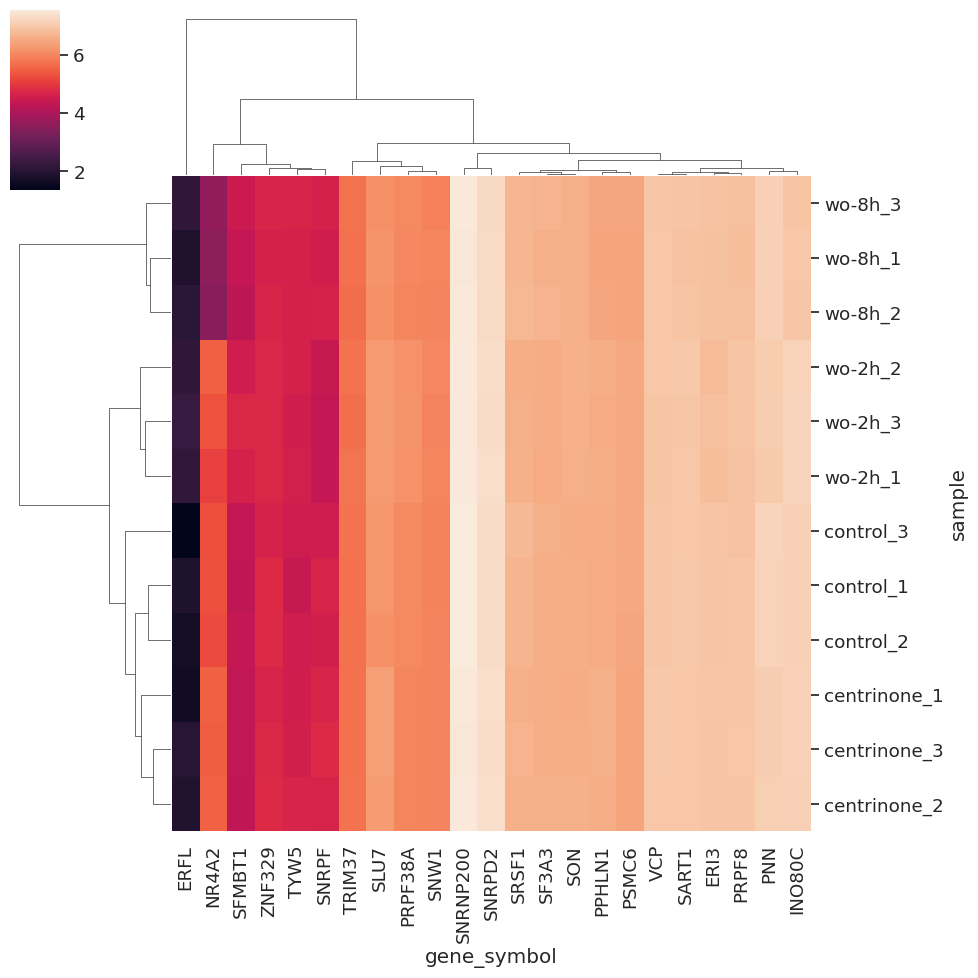

In [68]:
# plot a heatmap based on for the genes in list C
# Convert .X to dense (if sparse)
if sparse.issparse(c_adata.X):
    c_adata.X = c_adata.X.toarray()
sc.pl.clustermap(
    c_adata,
    use_raw=False,
    show=True
)

In [69]:
pseudobulk_adata

AnnData object with n_obs × n_vars = 12 × 1314
    obs: 'condition', 'replicate'
    var: 'ensembl_gene_id', 'gene_name', 'in_jakobsen', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'rank_genes_groups'

/home/jiguo/denovo_rpe1_scrnaseq/venvs/rna/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jiguo/denovo_rpe1_scrnaseq/venvs/rna/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


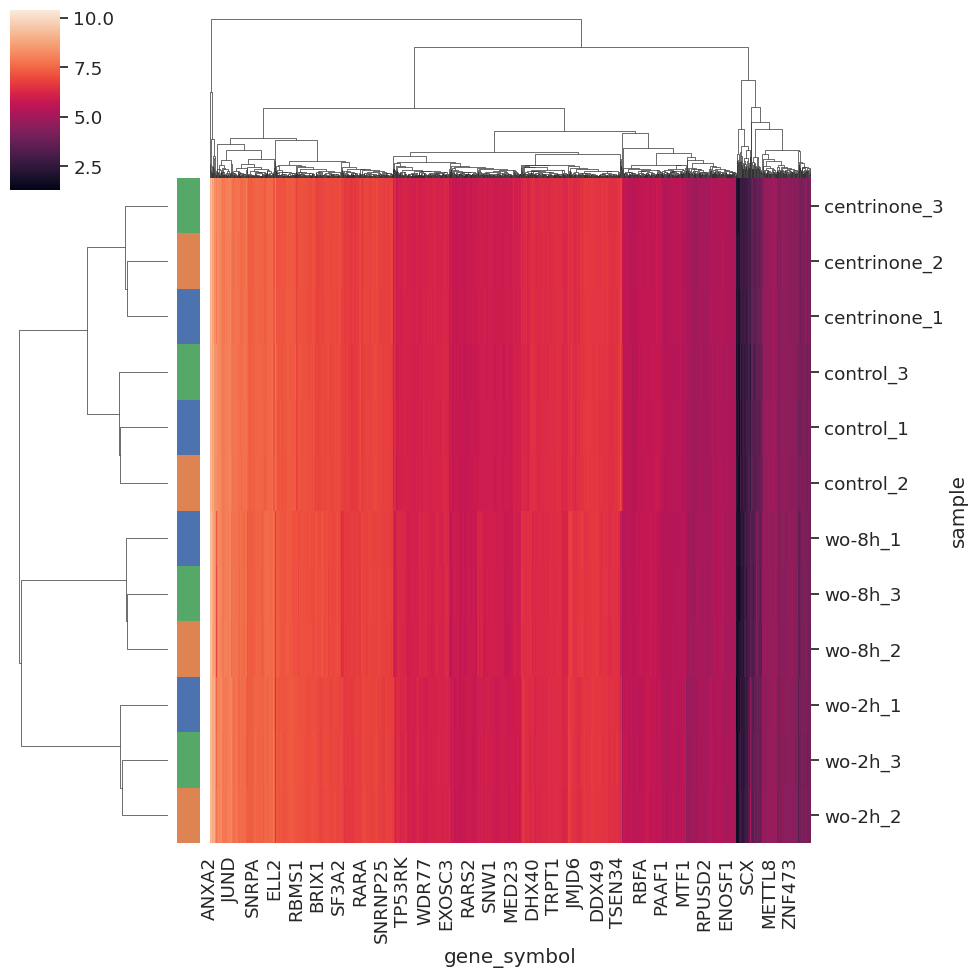

In [70]:
if sparse.issparse(pseudobulk_adata.X):
    pseudobulk_adata.X = pseudobulk_adata.X.toarray()
# 
sc.pl.clustermap(
    pseudobulk_adata,
    use_raw=False,
    show=False,
    obs_keys = 'replicate',
)

In [73]:
def plot_specila_volcano(de_results, control_condition):
    # Get conditions from de_results keys, not adata.obs
    conditions = list(de_results.keys())
    n_conditions = len(conditions)
    mRNA_genes = pd.read_csv("/home/jiguo/denovo_rpe1_scrnaseq/mRNA_processing.txt",delimiter='\t')['Gene_name'].tolist()
    rRNA_genes = pd.read_csv("/home/jiguo/denovo_rpe1_scrnaseq/rRNA_processing.txt",delimiter='\t')['Gene_name'].tolist()
    tRNA_genes = pd.read_csv("/home/jiguo/denovo_rpe1_scrnaseq/tRNA_processing.txt",delimiter='\t')['Gene_name'].tolist()
    # Calculate grid dimensions
    n_cols = min(2, n_conditions)
    n_rows = (n_conditions + n_cols - 1) // n_cols
    plt.figure(figsize=(15, 6*n_rows))
    sns.set(style='whitegrid', font_scale=1.2)
    
    for i, cond in enumerate(conditions, 1):
        df = de_results[cond]
        ax = plt.subplot(n_rows, n_cols, i)  # Fixed index: use i not i+1
        
        # Significance thresholds (use pvals_adj for FDR)
        sig_threshold = 0.05
        logfc_threshold = 1
        
        df['significance'] = 'Not significant'
        
        # Highlight mRNA processing genes
        df['is_mRNA'] = df['gene_name'].isin(mRNA_genes)
        df['is_rRNA'] = df['gene_name'].isin(rRNA_genes)
        df['is_tRNA'] = df['gene_name'].isin(tRNA_genes)
        df['significance'] = np.where(df['is_rRNA'], 'rRNA processing', df['significance'])
        df['significance'] = np.where(df['is_tRNA'], 'tRNA processing', df['significance'])
        df['significance'] = np.where(df['is_mRNA'], 'mRNA processing', df['significance'])
        df['significance'] = pd.Categorical(df['significance'], 
                                            categories=['mRNA processing', 'rRNA processing', 'tRNA processing','Not significant'],)
        # Use a consistent color palette
        sns.scatterplot(
            data=df,
            x='logfoldchanges',
            y='-log10_pvals_adj',  # Match the column name
            hue='significance',
            palette={
                'mRNA processing': '#ff7f00',  # Orange for mRNA processing genes
                'rRNA processing': '#4daf4a',  # Green for rRNA processing genes
                'tRNA processing': '#ff00ff',  # Magenta for tRNA processing genes
                'Not significant': '#bdbdbd'  # Gray for non-significant genes
            },
            alpha=0.7,
            s=40,
            ax=ax
        )
        # Gene labeling - better approach
        df['combined_score'] = np.abs(df['logfoldchanges']) * df['-log10_pvals_adj']
        top_genes = df.nlargest(10, 'combined_score')

        for _, row in top_genes.iterrows():
            ax.text(
                row['logfoldchanges'],
                row['-log10_pvals_adj'] + 0.1,  # Offset to avoid overlap
                row['gene_name'],
                fontsize=9,
                alpha=0.8,
                fontweight='bold'
            )
        # Add thresholdsa
        ax.axhline(-np.log10(sig_threshold), color='gray', linestyle='--', alpha=0.7)
        ax.axvline(logfc_threshold, color='gray', linestyle='--', alpha=0.7)
        ax.axvline(-logfc_threshold, color='gray', linestyle='--', alpha=0.7)
        # Correct title
        ax.set_title(f'{control_condition} vs {cond}', fontsize=16)  # Fixed title
        ax.set_xlabel('Log2 Fold Change', fontsize=14)
        ax.set_ylabel('-Log10(Adjusted p-value)', fontsize=14)
        ax.set_xlim(df['logfoldchanges'].min()-0.5, df['logfoldchanges'].max()+0.5)
        ax.legend().remove()  # Remove individual legends
    
    # Add common legend
    plt.tight_layout()
    handles, labels = ax.get_legend_handles_labels()
    plt.figlegend(handles, labels, loc='lower center', ncol=3)

    
    return plt

DE results saved to /home/jiguo/output/pseudobulk_analysis/de_results_control.csv with condition information


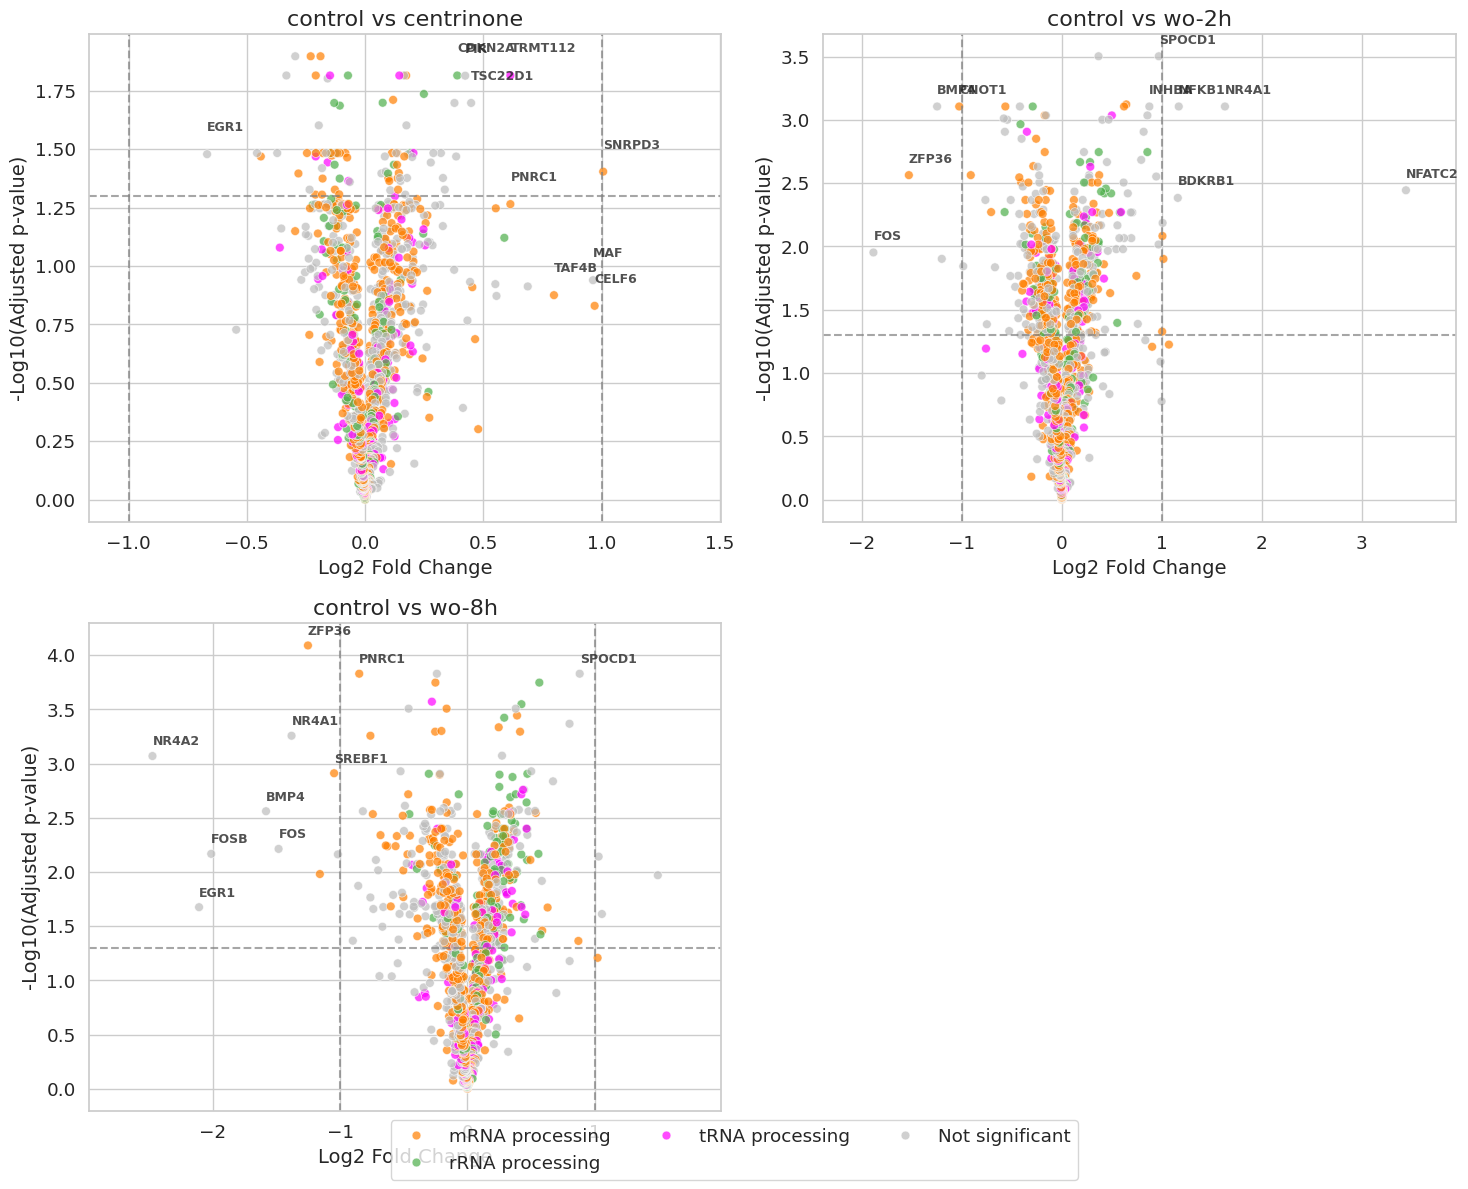

In [74]:
# First run DE analysis
sc.tl.rank_genes_groups(
    pseudobulk_adata,
    groupby='condition',
    reference='control',  # Set control as reference
    method='t-test_overestim_var'
)
# Extract results
de_results, control_condition = extract_de_results(
    pseudobulk_adata, 
    condition='control'  # Specify control condition
)

# Plot
fig = plot_specila_volcano(de_results, control_condition)
plt.show()

DE results saved to /home/jiguo/output/pseudobulk_analysis/de_results_centrinone.csv with condition information


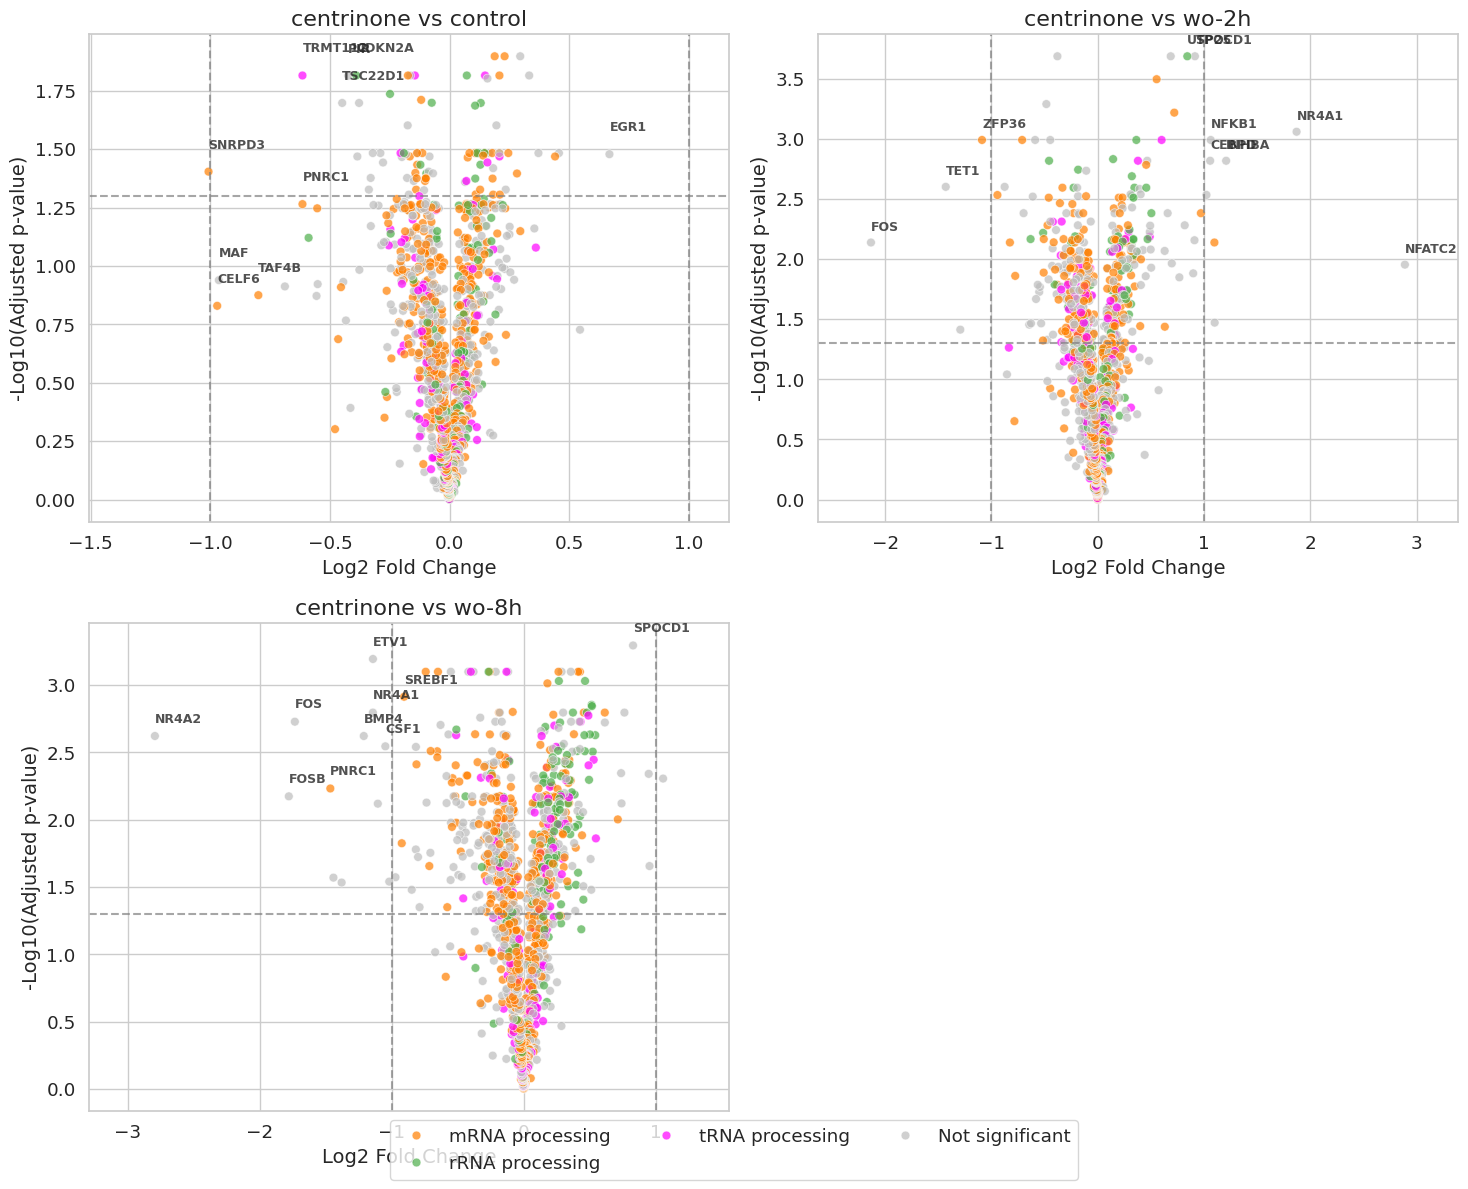

In [75]:
# First run DE analysis
sc.tl.rank_genes_groups(
    pseudobulk_adata,
    groupby='condition',
    reference='centrinone',  # Set control as reference
    method='t-test_overestim_var'
)
# Extract results
de_results, control_condition = extract_de_results(
    pseudobulk_adata, 
    condition='centrinone'  # Specify control condition
)

# Plot
fig = plot_specila_volcano(de_results, control_condition)
plt.show()

DE results saved to /home/jiguo/output/pseudobulk_analysis/de_results_wo-2h.csv with condition information


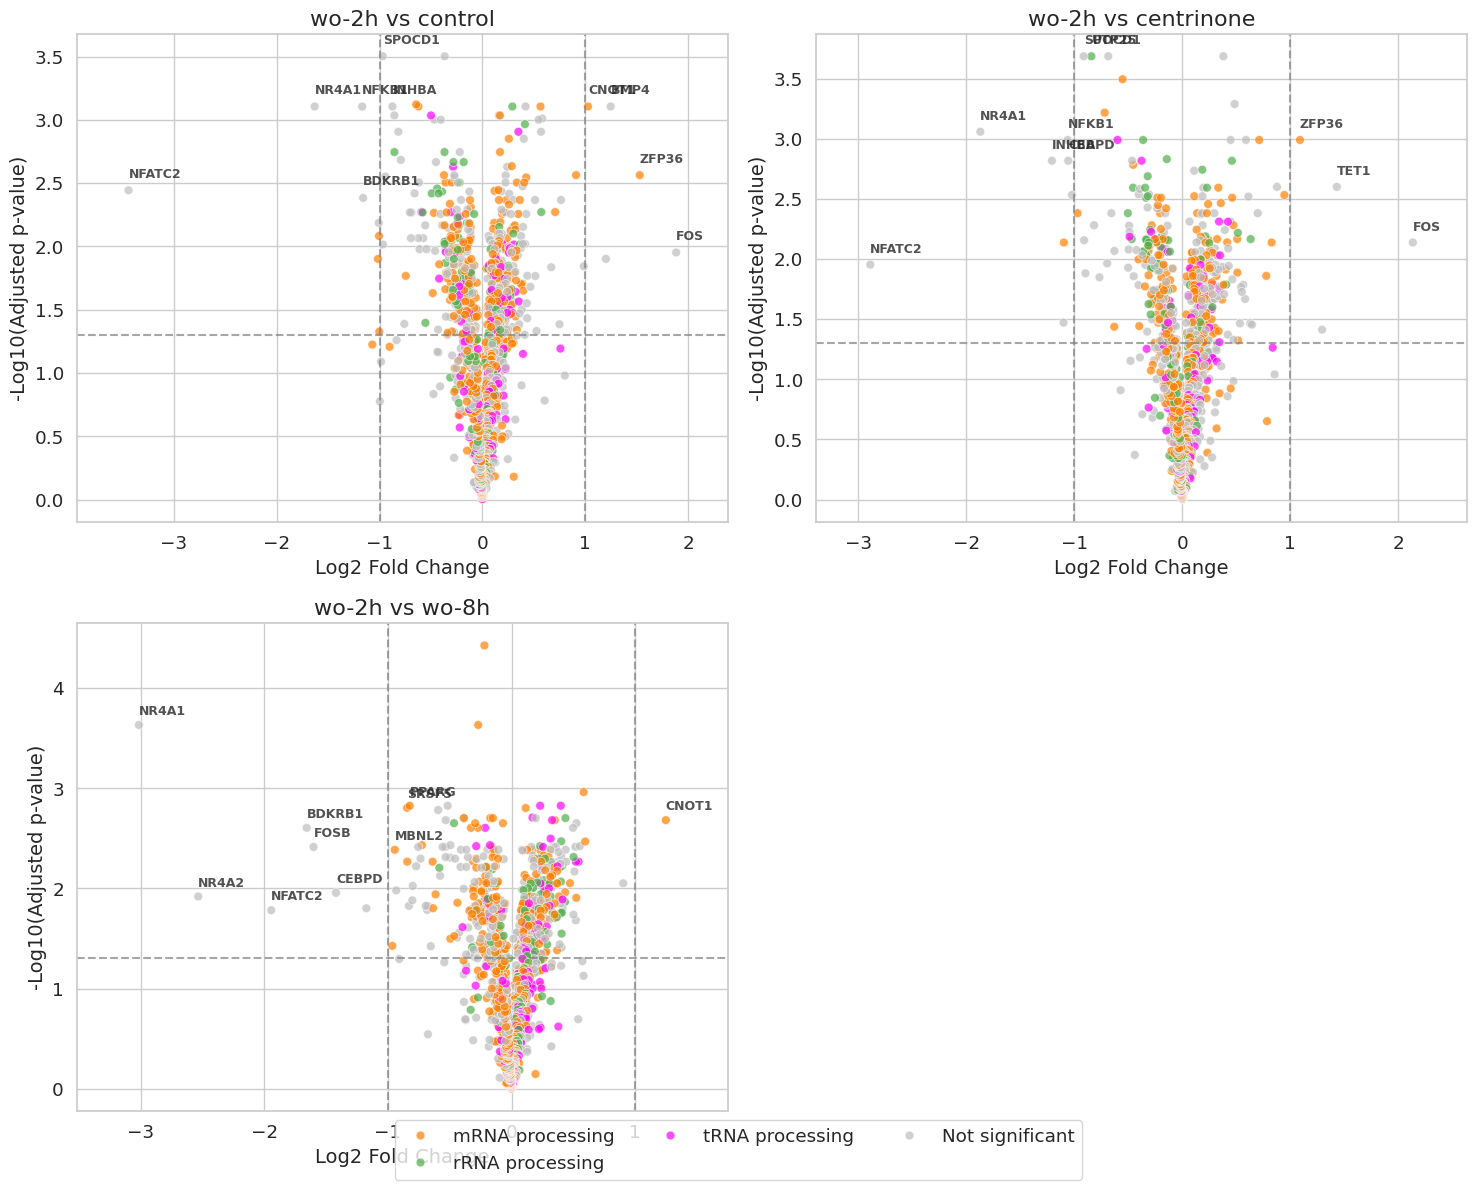

In [76]:
# First run DE analysis
sc.tl.rank_genes_groups(
    pseudobulk_adata,
    groupby='condition',
    reference='wo-2h',  # Set control as reference
    method='t-test_overestim_var'
)
# Extract results
de_results, control_condition = extract_de_results(
    pseudobulk_adata, 
    condition='wo-2h'  # Specify control condition
)

# Plot
fig = plot_specila_volcano(de_results, control_condition)
plt.show()